In [59]:
import pandas as pd
import itertools
import numpy as np
from collections import Counter
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
from tqdm import tqdm
import pickle
from sklearn.preprocessing import KBinsDiscretizer
from feature_engine.discretisers import EqualFrequencyDiscretiser
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns



In [3]:
pd.set_option("display.max_columns", 500)
pd.set_option("display.max_rows", 500)
pd.set_option("display.precision", 4)

# Load datasets

In [4]:
company = pd.read_csv('data/companies.csv')
rounds = pd.read_csv('data/rounds.csv')
investments = pd.read_csv('data/investments.csv')
acquisitions = pd.read_csv('data/acquisitions.csv')

# Data Cleaning

In [5]:
# want rows that have founded date informaton
company = company[~company.founded_at.isna()]
company = company[(company['founded_at'] > '1800') & (company['founded_at'] < '2014')]

In [6]:
# subset for only USA and Canada companies
company_us = company[(company.country_code=='USA') | (company.country_code=='CAN')]

In [7]:
# drop homepage_url, region and city 
company_us = company_us.drop(columns=(['homepage_url', 'region', 'city']))

In [8]:
# fill '-' with NaNs and convert 'funding_total_usd' to numeric
company_us.funding_total_usd.replace('-', np.nan, inplace=True)
company_us.funding_total_usd = pd.to_numeric(company_us.funding_total_usd)

In [9]:
# find values for missing first_funding_date
company_first_funding = rounds.groupby('company_permalink')['funded_at'].min().reset_index()
company_first_funding.rename(columns={'company_permalink':'permalink'}, inplace=True)

company_us = company_us.merge(company_first_funding, on='permalink')
company_us.drop(columns='first_funding_at', inplace=True)
company_us.rename(columns={'funded_at':'first_funding_at'}, inplace=True)

In [10]:
# find values for missing last_funding_date
company_last_funding = rounds.groupby('company_permalink')['funded_at'].max().reset_index()
company_last_funding.rename(columns={'company_permalink':'permalink'}, inplace=True)

company_us = company_us.merge(company_last_funding, on='permalink')
company_us.drop(columns='last_funding_at', inplace=True)
company_us.rename(columns={'funded_at':'last_funding_at'}, inplace=True)

In [11]:
# convert dates to date time format
company_us.first_funding_at = pd.to_datetime(company_us['first_funding_at'])
company_us.last_funding_at = pd.to_datetime(company_us['last_funding_at'])
company_us.founded_at = pd.to_datetime(company_us['founded_at'])

In [12]:
# only include operating companies that are at less than 10 years old
last_day = company_us.last_funding_at.max()

company_us = company_us[np.logical_or(
    company_us.status != 'operating',
    np.logical_or(
        np.logical_and(company_us.status=='operating',
            company_us.first_funding_at < last_day-pd.DateOffset(years=10)),
                np.logical_and(
                    np.logical_and(
                        company_us.status=='operating',
                        company_us.first_funding_at >= last_day-pd.DateOffset(years=10)),
                    company_us.last_funding_at < last_day-pd.DateOffset(months=30) 
    )
)
)].reset_index(drop=True)

In [13]:
# find age of company
company_us['age'] = company_us.apply(lambda x: relativedelta(last_day, x['founded_at']).years, axis=1)

In [14]:
# find age of company when it received first funding
company_us['age_first_funding'] = company_us.apply(lambda x: relativedelta(x['first_funding_at'], x['founded_at']).years, axis=1)

In [15]:
# create binary target of whether company ipo or acquired
company_us['target'] = ""

company_us.loc[(company_us.status=='operating') | (company_us.status=='closed'), 'target'] = 0
company_us.loc[(company_us.status=='ipo') | (company_us.status=='acquired'), 'target'] = 1

# shorten the list of category list

In [16]:
company_us = company_us.dropna(subset=['category_list'])
company_us = company_us.reset_index(drop='index')

In [17]:
# create a list of category lists
categories = company_us['category_list'].apply(lambda x: sorted(str(x).strip().split('|')))
categories = [item for sublist in categories for item in sublist]
categories = pd.DataFrame(categories, columns=['category'])

In [18]:
# look at top categories by counts
categories.value_counts(normalize=True).cumsum().head(50)

category            
Software                0.0747
Mobile                  0.1138
Biotechnology           0.1527
Curated Web             0.1845
Enterprise Software     0.2095
Social Media            0.2330
E-Commerce              0.2560
Advertising             0.2791
Games                   0.2984
Health Care             0.3142
Analytics               0.3275
Hardware + Software     0.3407
Finance                 0.3536
Health and Wellness     0.3664
Clean Technology        0.3781
SaaS                    0.3897
Education               0.4010
Video                   0.4104
Security                0.4199
Technology              0.4289
Manufacturing           0.4377
Internet                0.4465
Networking              0.4549
Web Hosting             0.4630
Semiconductors          0.4705
Search                  0.4777
Consulting              0.4849
Cloud Computing         0.4920
News                    0.4989
Apps                    0.5058
Messaging               0.5125
Music             

In [19]:
# come up with new categories from list of 400+ categories
new_categories = ['software', 'mobile', 'biotechnology', 'clean technology', 'energy', 'commerce', 'media', 'information tech', 'health care', 'education', 'financial', 'manufaturing', 'hardware', 'security', 'real estate', 'entertainment', 'internet services', 'government', 'security', 'transportation', 'entertainment', 'apps', 'news', 'search', 'messaging', 'music', 'fashion', 'marketing', 'consulting', 'advertising', 'analytics', 'cloud computing']

In [20]:
# split the categories to look at individual items
company_us['category_list'] = company_us['category_list'].apply(lambda x: ', '.join(str(x).strip().split('|')) if pd.notnull(x) else x)

company_us['category_list'] = company_us['category_list'].apply(lambda x: x.lower() if pd.notnull(x) else x)

In [21]:
# utilize fuzzywuzzy to find best matching categories
update_category = []
for i in tqdm(range(len(company_us))):
    if pd.notnull(company_us.category_list[i]):
        highest = process.extractOne(company_us['category_list'][i], new_categories)
        update_category.append(highest[0])
    else:
        update_category.append('other')


100%|██████████| 15686/15686 [03:10<00:00, 82.16it/s]


In [22]:
company_us['category_list'] = pd.DataFrame(update_category)

# Shorten list of states

In [23]:
company_us.state_code.value_counts().head(10)

CA    5529
NY    1468
MA    1058
TX     730
WA     553
FL     472
IL     438
CO     372
PA     367
ON     337
Name: state_code, dtype: int64

In [24]:
# come up with 5 category of states
state_list = ['CA', 'NY', 'MA', 'TX']

company_us['state_code'] = company_us['state_code'].apply(lambda x: x if str(x) in state_list else 'other')

# Get rid of outliers in funding_total_usd

{'whiskers': [<matplotlib.lines.Line2D at 0x7f8b6a4ffc10>,
 'caps': [<matplotlib.lines.Line2D at 0x7f8b6a4e1ed0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f8b6a70c210>],
 'medians': [<matplotlib.lines.Line2D at 0x7f8b6a4c3f90>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f8b6a534810>],
 'means': []}

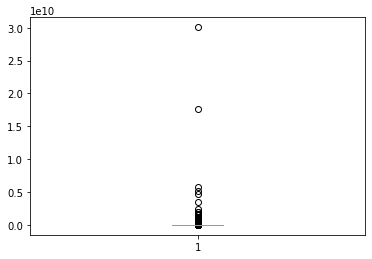

In [25]:
# two huge outliers so want to get rid of them
plt.boxplot(company_us[~company_us.funding_total_usd.isna()].funding_total_usd)

In [26]:
company_us = company_us.sort_values(by='funding_total_usd', ascending=False)[2:]

In [27]:
company_us = company_us.reset_index(drop='index')

## number of investments / amount invested by top VCs

In [28]:
# add target variable to investment data 
investments_invest = investments[(investments['investor_country_code']=='USA') | (investments['investor_country_code']=='CAN')]
returns = investments_invest.merge(company_us[['permalink', 'target']], how='left', left_on='company_permalink', right_on='permalink')
unique_returns = returns.drop_duplicates(subset=['permalink', 'investor_permalink'])

In [29]:
# look at amount raised for successful companies
success_money = returns[returns['target']==1].groupby('investor_permalink')['raised_amount_usd'].sum().reset_index()
success_money = success_money.rename(columns={'raised_amount_usd':'successful_money'})

In [30]:
company_invest = unique_returns.groupby(['investor_permalink'])['company_permalink'].count().reset_index().sort_values(by='company_permalink')

In [31]:
# counts of successful investments
investor_return = unique_returns.groupby('investor_permalink')['target'].sum().reset_index().sort_values('target')

In [32]:
total_put = returns[['investor_permalink', 'raised_amount_usd']].groupby('investor_permalink').sum().reset_index()

In [33]:
company_invest = company_invest.merge(investor_return, left_on='investor_permalink', right_on='investor_permalink')
company_invest = company_invest.merge(total_put, left_on='investor_permalink', right_on='investor_permalink').sort_values(by='company_permalink', ascending=False)
company_invest = company_invest.merge(success_money, left_on='investor_permalink', right_on='investor_permalink').head(20).sort_values(by='company_permalink')

In [34]:
company_invest_usd = company_invest.sort_values(by='raised_amount_usd', ascending=True)
company_invest_usd.head()

,investor_permalink,company_permalink,target,raised_amount_usd,successful_money
9,/organization/techstars,131,51,2.7791e+08,1.0699e+07
1,/organization/y-combinator,233,74,6.6387e+08,4.9979e+07
4,/organization/500-startups,184,56,1.2955e+09,1.3652e+08
0,/organization/sv-angel,255,147,3.6080e+09,6.2226e+08
18,/organization/charles-river-ventures,103,57,4.1064e+09,1.1724e+09


[Text(0.0, 0, '0'),
 Text(5000000000.0, 0, '5'),
 Text(10000000000.0, 0, '10'),
 Text(15000000000.0, 0, '15'),
 Text(20000000000.0, 0, '20'),
 Text(25000000000.0, 0, '25'),
 Text(30000000000.0, 0, '')]

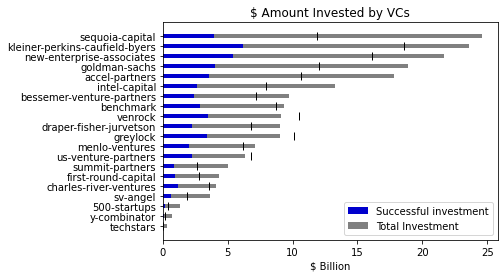

In [35]:
width = 0.35       # the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots()

ax.barh(company_invest_usd['investor_permalink'].apply(lambda x: x.split('/')[2]), company_invest_usd['successful_money'], width, label='Successful investment', color='mediumblue')
ax.barh(company_invest_usd['investor_permalink'].apply(lambda x: x.split('/')[2]), company_invest_usd['raised_amount_usd']-company_invest_usd['successful_money'], width, left=company_invest_usd['successful_money'],label='Total Investment', color='grey')
ax.barh(company_invest_usd['investor_permalink'].apply(lambda x: x.split('/')[2]), width, left=company_invest_usd['successful_money']*3, color='black', linestyle="-", ec='black')

ax.set_ylabel('')
ax.set_xlabel('$ Billion')
ax.set_title('$ Amount Invested by VCs')
ax.legend()
ax.axes.xaxis.set_ticklabels([0, 5, 10, 15, 20, 25])



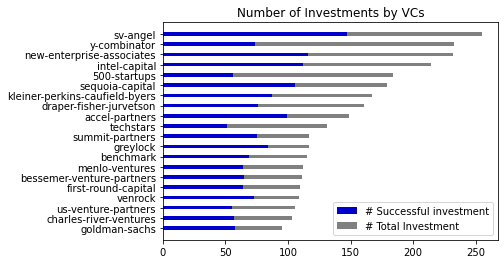

In [36]:
width = 0.35       # the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots()

ax.barh(company_invest['investor_permalink'].apply(lambda x: x.split('/')[2]), company_invest['target'], width, label='# Successful investment', color='mediumblue')
ax.barh(company_invest['investor_permalink'].apply(lambda x: x.split('/')[2]), company_invest['company_permalink']-company_invest['target'], width, left=company_invest['target'],
       label='# Total Investment', color='grey')
#ax.barh(company_invest['investor_permalink'].apply(lambda x: x.split('/')[2]), width, left=company_invest['company_permalink']*0.5, color='black')
ax.set_ylabel('')
ax.set_title('Number of Investments by VCs')
ax.legend()



# add investment data to df

In [37]:
investments = investments[(investments['company_country_code']=='USA') | (investments['company_country_code']=='CAN')]

In [38]:
# calculate total number of investments a company receives
total_investments = investments[['company_permalink', 'investor_permalink']].groupby(['company_permalink']).count().reset_index()
total_investments = total_investments.rename(columns={'company_permalink':'permalink', 'investor_permalink':'num_investments'})

In [39]:
# calculate unique number of investors
unique_investors = investments.groupby(['company_permalink', 'investor_permalink']).count().reset_index()
unique_investors = unique_investors.iloc[:, 0:3]
unique_investors = unique_investors.groupby(['company_permalink']).count().reset_index()
unique_investors = unique_investors.iloc[:, 0:2]
unique_investors = unique_investors.rename(columns={'company_permalink':'permalink', 'investor_permalink':'num_unique_investors'})

In [40]:
# add total number of investments and number of investors to df
company_us = pd.merge(how='left', left=company_us, right=total_investments, left_on='permalink', right_on='permalink')
company_us = pd.merge(how='left', left=company_us, right=unique_investors, left_on='permalink', right_on='permalink')

In [41]:
# get list of top 500 investors
top_500_investors = investments.groupby(['investor_permalink', 'investor_name']).size().reset_index(name='counts').sort_values(by='counts', ascending=False).head(500)
is_vc = top_500_investors[top_500_investors['investor_name'].str.contains('Ventures')].investor_permalink.reset_index()

In [42]:
# calculate number of top 500 investors in company
has_top_investors = investments.groupby(['company_permalink', 'investor_permalink']).count().reset_index()
has_top_investors = has_top_investors.iloc[:, 0:3]
has_top_investors['num_top500_investors'] = has_top_investors.investor_permalink.isin(top_500_investors.investor_permalink)
has_top_investors['vc'] = has_top_investors.investor_permalink.isin(is_vc.investor_permalink)
is_vc = has_top_investors.groupby('company_permalink')['vc'].max().reset_index()
is_vc = is_vc.rename(columns={'company_permalink':'permalink'})

has_top_investors = has_top_investors.groupby('company_permalink')['num_top500_investors'].sum().reset_index()
has_top_investors = has_top_investors.rename(columns={'company_permalink':'permalink'})

In [43]:
company_us = pd.merge(how='left', left=company_us, right=has_top_investors, left_on='permalink', right_on='permalink')
company_us = pd.merge(how='left', left=company_us, right=is_vc, left_on='permalink', right_on='permalink')

In [44]:
# create binary variable to capture whether each row had specific information or not
# give more weight to rows that have more information
company_us['has_vc'] = company_us['vc'].apply(lambda x: 1 if pd.notnull(x) else 0)
company_us['has_investors'] = company_us['num_investments'].apply(lambda x: 1 if pd.notnull(x) else 0)
company_us['has_unique_investors'] = company_us['num_unique_investors'].apply(lambda x: 1 if pd.notnull(x) else 0)
company_us['has_top500_investors'] = company_us['num_top500_investors'].apply(lambda x: 1 if pd.notnull(x) else 0)
company_us['vc'] = company_us['vc'].apply(lambda x: 1 if x==True else 0)

# add rounds data to df

In [45]:
rounds_us = rounds[(rounds['company_country_code']=='USA') | (rounds['company_country_code']=='CAN')]

In [46]:
# average investment amount
average_raise = rounds_us.groupby('company_permalink').agg({  
    'raised_amount_usd': 'mean'}).rename(
    columns={
        'raised_amount_usd': 'investment_per_round'
    }).reset_index()

In [47]:
rounds_us = rounds_us.merge(company[['permalink', 'founded_at']], left_on='company_permalink', right_on='permalink')

In [48]:
# replace 'NaN' in funding_round_code with 'seed' if funding_round_type is 'seed'
rounds_us['funding_round_code'] = rounds_us.apply(lambda x: 'seed' if x['funding_round_type']=='seed' else x['funding_round_code'], axis=1)

# replace 'NaN' in funding_round_code with 'angel' if funding_round_type is 'angel'
rounds_us['funding_round_code'] = rounds_us.apply(lambda x: 'angel' if x['funding_round_type']=='angel' else x['funding_round_code'], axis=1)

In [49]:
# get rid of rows that contain information after ipo
rounds_us = rounds_us[(rounds_us['funding_round_type']!='post_ipo_debt') | (rounds_us['funding_round_type']!='post_ipo_equity')]

In [50]:
# rounds_us['seedround'] = rounds_us['funding_round_code'].apply(lambda x: 1 if x=='seed' else 0)
rounds_us['roundA'] = rounds_us['funding_round_code'].apply(lambda x: 1 if x=='A' else 0)
rounds_us['roundB'] = rounds_us['funding_round_code'].apply(lambda x: 1 if x=='B' else 0)
rounds_us['roundC'] = rounds_us['funding_round_code'].apply(lambda x: 1 if x=='C' else 0)
rounds_us['roundD'] = rounds_us['funding_round_code'].apply(lambda x: 1 if x=='D' else 0)

In [51]:
#rounds_us['seedround_raised_amount'] = rounds_us.apply(lambda x: x['raised_amount_usd'] if x['roundA']==1 else 0, axis=1)
rounds_us['roundA_raised_amount'] = rounds_us.apply(lambda x: x['raised_amount_usd'] if x['roundA']==1 else np.nan, axis=1)
rounds_us['roundB_raised_amount'] = rounds_us.apply(lambda x: x['raised_amount_usd'] if x['roundB']==1 else np.nan, axis=1)
rounds_us['roundC_raised_amount'] = rounds_us.apply(lambda x: x['raised_amount_usd'] if x['roundC']==1 else np.nan, axis=1)
rounds_us['roundD_raised_amount'] = rounds_us.apply(lambda x: x['raised_amount_usd'] if x['roundD']==1 else np.nan, axis=1)

In [52]:
# convert to datetime
rounds_us['funded_at'] = pd.to_datetime(rounds_us['funded_at'])
rounds_us['founded_at'] = pd.to_datetime(rounds_us['founded_at'])

In [53]:
# calculate time between each round and company's fonded date
#rounds_us['seedround_age'] = rounds_us.apply(lambda x: relativedelta(x['funded_at'], x['founded_at']).years if x['seedround']==1 else 0, axis=1)
rounds_us['roundA_age'] = rounds_us.apply(lambda x: relativedelta(x['funded_at'], x['founded_at']).years if x['roundA']==1 else 0, axis=1)
rounds_us['roundB_age'] = rounds_us.apply(lambda x: relativedelta(x['funded_at'], x['founded_at']).years if x['roundB']==1 else 0, axis=1)
rounds_us['roundC_age'] = rounds_us.apply(lambda x: relativedelta(x['funded_at'], x['founded_at']).years if x['roundC']==1 else 0, axis=1)
rounds_us['roundD_age'] = rounds_us.apply(lambda x: relativedelta(x['funded_at'], x['founded_at']).years if x['roundD']==1 else 0, axis=1)

In [54]:
# group company by the age at specific round
rounds_age = rounds_us.groupby('company_permalink')['roundA_age', 'roundB_age', 'roundC_age', 'roundD_age'].max().reset_index()

In [55]:
# group company by whether company completed specific round
rounds_rounds = rounds_us.groupby('company_permalink')['roundA', 'roundB', 'roundC', 'roundD'].max().reset_index()

In [56]:
# group company by amount raised at specific round
rounds_raised = rounds_us.groupby('company_permalink')['roundA_raised_amount', 'roundB_raised_amount', 'roundC_raised_amount', 'roundD_raised_amount'].sum(min_count=1).reset_index()

In [57]:
# merge all necessary dataframes to final df
final_df = company_us.merge(rounds_rounds, left_on='permalink', right_on='company_permalink').drop('company_permalink', axis=1)
final_df = final_df.merge(rounds_age, left_on='permalink', right_on='company_permalink').drop('company_permalink', axis=1)
final_df = final_df.merge(rounds_raised, left_on='permalink', right_on='company_permalink').drop('company_permalink', axis=1)
final_df = final_df.merge(average_raise, left_on='permalink', right_on='company_permalink').drop('company_permalink', axis=1)

# Look for feature interaction

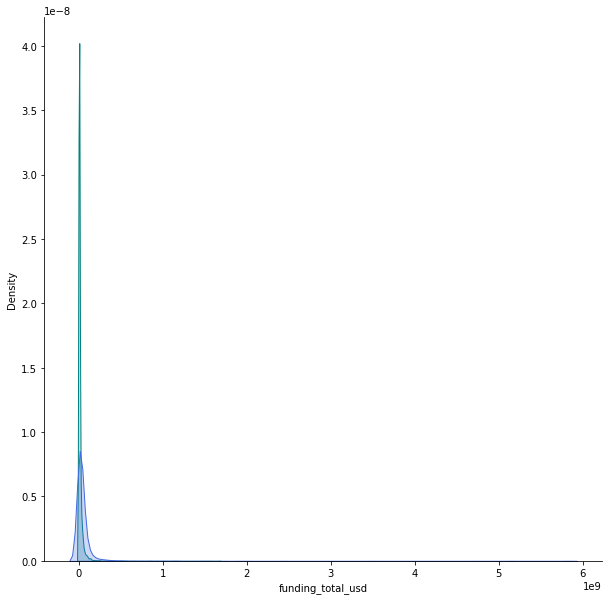

In [63]:
plt.figure(figsize=(10,10))
sns.kdeplot(final_df[final_df.target == 0]['funding_total_usd'],
            label='Fail',
            shade=True,
            color='teal')
sns.kdeplot(final_df[final_df.target == 1]['funding_total_usd'],
            label='Success',
            shade=True,
            color='royalblue')
sns.despine()

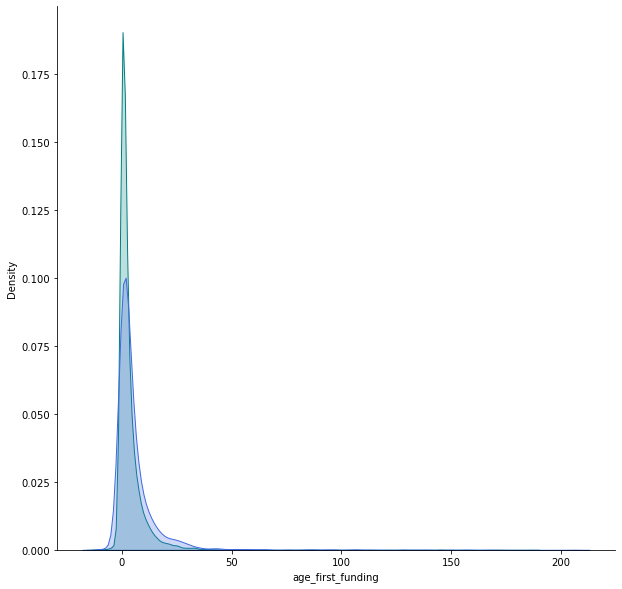

In [64]:
plt.figure(figsize=(10,10))
sns.kdeplot(final_df[final_df.target == 0]['age_first_funding'],
            label='Fail',
            shade=True,
            color='teal')
sns.kdeplot(final_df[final_df.target == 1]['age_first_funding'],
            label='Success',
            shade=True,
            color='royalblue')
sns.despine()

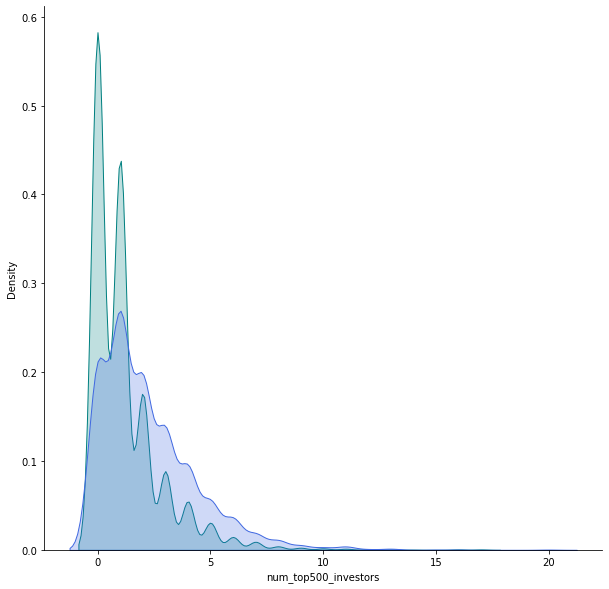

In [65]:
plt.figure(figsize=(10,10))
sns.kdeplot(final_df[final_df.target == 0]['num_top500_investors'],
            label='Fail',
            shade=True,
            color='teal')
sns.kdeplot(final_df[final_df.target == 1]['num_top500_investors'],
            label='Success',
            shade=True,
            color='royalblue')
sns.despine()

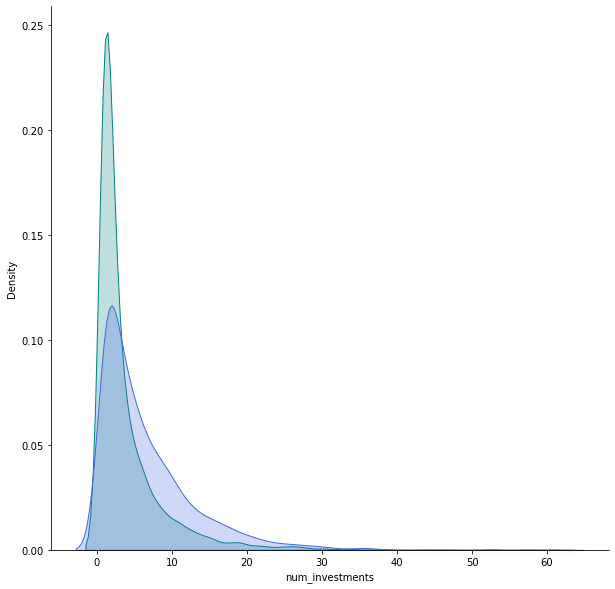

In [66]:
plt.figure(figsize=(10,10))
sns.kdeplot(final_df[final_df.target == 0]['num_investments'],
            label='Fail',
            shade=True,
            color='teal')
sns.kdeplot(final_df[final_df.target == 1]['num_investments'],
            label='Success',
            shade=True,
            color='royalblue')
sns.despine()

# Discretizing features into bins

In [85]:
final_df.isna().sum()

permalink                   0
name                        1
category_list               0
funding_total_usd        2390
status                      0
country_code                0
state_code                  0
funding_rounds              0
founded_at                  0
first_funding_at            0
last_funding_at             0
age                         0
age_first_funding           0
target                      0
num_investments          5775
num_unique_investors     5775
num_top500_investors     5775
vc                          0
has_vc                      0
has_investors               0
has_unique_investors        0
has_top500_investors        0
roundA                      0
roundB                      0
roundC                      0
roundD                      0
roundA_age                  0
roundB_age                  0
roundC_age                  0
roundD_age                  0
roundA_raised_amount    12401
roundB_raised_amount    13103
roundC_raised_amount    14079
roundD_rai

In [86]:
# create a binary feature of whether a company had a specific round
# need to have both completed a specific round and have amount for that round
final_df['has_roundA'] = final_df.apply(lambda x: 1 if np.logical_and(x['roundA']==1, x['roundA_raised_amount'] > 0.5) else 0, axis=1)
final_df['has_roundB'] = final_df.apply(lambda x: 1 if np.logical_and(x['roundB']==1, x['roundB_raised_amount'] > 0.5) else 0, axis=1)
final_df['has_roundC'] = final_df.apply(lambda x: 1 if np.logical_and(x['roundC']==1, x['roundC_raised_amount'] > 0.5) else 0, axis=1)
final_df['has_roundD'] = final_df.apply(lambda x: 1 if np.logical_and(x['roundD']==1, x['roundD_raised_amount'] > 0.5) else 0, axis=1)
final_df['hasfunding'] = final_df['funding_total_usd'].apply(lambda x: 1 if pd.notnull(x) else 0)

final_df.drop(columns=['roundA', 'roundB', 'roundC', 'roundD'], inplace=True)

In [87]:
# replace NaN with 0 now that we have binary feature to capture whether each row has that information or not
final_df[['investment_per_round', 'funding_total_usd', 'num_investments', 'num_unique_investors', 'num_top500_investors', 'roundA_raised_amount', 'roundB_raised_amount', 'roundC_raised_amount', 'roundD_raised_amount']] = final_df[['investment_per_round', 'funding_total_usd', 'num_investments', 'num_unique_investors', 'num_top500_investors', 'roundA_raised_amount', 'roundB_raised_amount', 'roundC_raised_amount', 'roundD_raised_amount']].replace(np.nan, 0)

In [88]:
# bin funding_total_usd
disc = EqualFrequencyDiscretiser(q=4, variables=['funding_total_usd'])
disc.fit_transform(final_df)
print(disc.binner_dict_)

final_df['funding_total_usd(-inf-130000]'] = final_df['funding_total_usd'].apply(lambda x: 1 if x<=130000 else 0)
final_df['funding_total_usd(130000-1806473]'] = final_df['funding_total_usd'].apply(lambda x: 1 if 130000<x<=1806473 else 0)
final_df['funding_total_usd(1806473-12200000]'] = final_df['funding_total_usd'].apply(lambda x: 1 if 1806473<x<=12200000 else 0)
final_df['funding_total_usd(12200000-inf]'] = final_df['funding_total_usd'].apply(lambda x: 1 if 12200000<x else 0)

final_df.drop(columns='funding_total_usd', inplace=True)



{'funding_total_usd': [-inf, 130000.0, 1806473.0, 12200000.0, inf]}


In [89]:
# bin investment_per_round
disc = EqualFrequencyDiscretiser(q=4, variables=['investment_per_round'])
disc.fit_transform(final_df)
print(disc.binner_dict_)

final_df['investment_per_round(-inf-115000]'] = final_df['investment_per_round'].apply(lambda x: 1 if x<=115000 else 0)
final_df['investment_per_round(115000-1300000]'] = final_df['investment_per_round'].apply(lambda x: 1 if 115000<x<=1300000 else 0)
final_df['investment_per_round(1300000-6510833.5]'] = final_df['investment_per_round'].apply(lambda x: 1 if 1300000<x<=6510833.5 else 0)
final_df['investment_per_round(6510833.5-inf]'] = final_df['investment_per_round'].apply(lambda x: 1 if 6510833.5<x else 0)

final_df.drop(columns='investment_per_round', inplace=True)



{'investment_per_round': [-inf, 115000.0, 1300000.0, 6510833.5, inf]}


In [90]:
# bin num_unique_investors
disc = EqualFrequencyDiscretiser(q=8, variables=['num_unique_investors'])
disc.fit_transform(final_df)
print(disc.binner_dict_)

final_df['num_unique_investors(-inf-0.5]'] = final_df['num_unique_investors'].apply(lambda x: 1 if x<=1.5 else 0)
final_df['num_unique_investors(0.5-2.5]'] = final_df['num_unique_investors'].apply(lambda x: 1 if 1.5<x<=2.5 else 0)
final_df['num_unique_investors(2.5-4.5]'] = final_df['num_unique_investors'].apply(lambda x: 1 if 2.5<x<=4.5 else 0)
final_df['num_unique_investors(4.5-inf]'] = final_df['num_unique_investors'].apply(lambda x: 1 if 4.5<x else 0)

final_df.drop(columns='num_unique_investors', inplace=True)



{'num_unique_investors': [-inf, 1.0, 2.0, 3.0, 5.0, inf]}


In [91]:
# bin age
disc = EqualFrequencyDiscretiser(q=4, variables=['age'])
disc.fit_transform(final_df)
print(disc.binner_dict_)

final_df['age(-inf-4.5]'] = final_df['age'].apply(lambda x: 1 if x<4.5 else 0)
final_df['age(4.5-7.5]'] = final_df['age'].apply(lambda x: 1 if 4.5<x<7.5 else 0)
final_df['age(7.5-12.5]'] = final_df['age'].apply(lambda x: 1 if 7.5<x<12.5 else 0)
final_df['age(12.5-inf]'] = final_df['age'].apply(lambda x: 1 if 12.5<x else 0)

final_df.drop(columns='age', inplace=True)



{'age': [-inf, 5.0, 8.0, 13.0, inf]}


In [92]:
# bin age_first_funding
disc = EqualFrequencyDiscretiser(q=5, variables=['age_first_funding'])
disc.fit_transform(final_df)
print(disc.binner_dict_)

final_df['age_first_funding(-inf-0.5]'] = final_df['age_first_funding'].apply(lambda x: 1 if x<0.5 else 0)
final_df['age_first_funding(0.5-1.5]'] = final_df['age_first_funding'].apply(lambda x: 1 if 0.5<x<1.5 else 0)
final_df['age_first_funding(1.5-5.5]'] = final_df['age_first_funding'].apply(lambda x: 1 if 1.5<x<5.5 else 0)
final_df['age_first_funding(5.5-inf]'] = final_df['age_first_funding'].apply(lambda x: 1 if 5.5<x else 0)

final_df.drop(columns='age_first_funding', inplace=True)



{'age_first_funding': [-inf, 0.0, 1.0, 2.0, 6.0, inf]}


In [93]:
# bin funding_rounds
disc = EqualFrequencyDiscretiser(q=15, variables=['funding_rounds'])
disc.fit_transform(final_df)
print(disc.binner_dict_)

final_df['funding_rounds(-inf-1.5]'] = final_df['funding_rounds'].apply(lambda x: 1 if x<1.5 else 0)
final_df['funding_rounds(1.5-2.5]'] = final_df['funding_rounds'].apply(lambda x: 1 if 1.5<x<2.5 else 0)
final_df['funding_rounds(2.5-3.5]'] = final_df['funding_rounds'].apply(lambda x: 1 if 2.5<x<3.5 else 0)
final_df['funding_rounds(3.5-inf]'] = final_df['funding_rounds'].apply(lambda x: 1 if 3.5<x else 0)

final_df.drop(columns='funding_rounds', inplace=True)




{'funding_rounds': [-inf, 2.0, 3.0, 4.0, inf]}


In [94]:
# bin num_top500_investors
disc = EqualFrequencyDiscretiser(q=10, variables=['num_top500_investors'])
disc.fit_transform(final_df)
print(disc.binner_dict_)

final_df['num_top500_investors(-inf-0.5]'] = final_df['num_top500_investors'].apply(lambda x: 1 if x<1.5 else 0)
final_df['num_top500_investors(0.5-1.5]'] = final_df['num_top500_investors'].apply(lambda x: 1 if 1.5<x<2.5 else 0)
final_df['num_top500_investors(1.5-2.5]'] = final_df['num_top500_investors'].apply(lambda x: 1 if 2.5<x<3.5 else 0)
final_df['num_top500_investors(2.5-inf]'] = final_df['num_top500_investors'].apply(lambda x: 1 if 3.5<x else 0)

final_df.drop(columns='num_top500_investors', inplace=True)




{'num_top500_investors': [-inf, 1.0, 2.0, 3.0, inf]}


In [95]:
# bin num_investments
disc = EqualFrequencyDiscretiser(q=8, variables=['num_investments'])
disc.fit_transform(final_df)
print(disc.binner_dict_)

final_df['num_investments(-inf-1.5]'] = final_df['num_investments'].apply(lambda x: 1 if x<1.5 else 0)
final_df['num_investments(1.5-2.5]'] = final_df['num_investments'].apply(lambda x: 1 if 1.5<x<2.5 else 0)
final_df['num_investments(2.5-4.5]'] = final_df['num_investments'].apply(lambda x: 1 if 2.5<x<4.5 else 0)
final_df['num_investments(4.5-inf]'] = final_df['num_investments'].apply(lambda x: 1 if 4.5<x else 0)

final_df.drop(columns='num_investments', inplace=True)



{'num_investments': [-inf, 1.0, 2.0, 4.0, 8.0, inf]}


In [96]:
# roundA_age
disc = EqualFrequencyDiscretiser(q=25, variables=['roundA_age'])
disc.fit_transform(final_df)
print(disc.binner_dict_)

final_df['roundA_age(-inf-1.5]'] = final_df['roundA_age'].apply(lambda x: 1 if x<1.5 else 0)
final_df['roundA_age(1.5-2.5]'] = final_df['roundA_age'].apply(lambda x: 1 if 1.5<x<2.5 else 0)
final_df['roundA_age(2.5-3.5]'] = final_df['roundA_age'].apply(lambda x: 1 if 2.5<x<3.5 else 0)
final_df['roundA_age(3.5-inf]'] = final_df['roundA_age'].apply(lambda x: 1 if 3.5<x else 0)

final_df.drop(columns='roundA_age', inplace=True)



{'roundA_age': [-inf, 0.0, 1.0, 2.0, 4.0, inf]}


In [97]:
# roundA_raised_amount
disc = EqualFrequencyDiscretiser(q=20, variables=['roundA_raised_amount'])
disc.fit_transform(final_df)
print(disc.binner_dict_)

final_df['roundA_raised_amount(-inf-2573250]'] = final_df['roundA_raised_amount'].apply(lambda x: 1 if x<=2573250 else 0)
final_df['roundA_raised_amount(2573250-5000000]'] = final_df['roundA_raised_amount'].apply(lambda x: 1 if 2573250<x<=5000000 else 0)
final_df['roundA_raised_amount(5000000-8434284]'] = final_df['roundA_raised_amount'].apply(lambda x: 1 if 5000000<x<=8434284 else 0)
final_df['roundA_raised_amount(8434284-inf]'] = final_df['roundA_raised_amount'].apply(lambda x: 1 if 8434284<x else 0)

final_df.drop(columns='roundA_raised_amount', inplace=True)




{'roundA_raised_amount': [-inf, 700000.0, 2573250.0000000163, 5000000.0, 8434284.000000002, inf]}


In [98]:
# roundB_age
disc = EqualFrequencyDiscretiser(q=25, variables=['roundB_age'])
disc.fit_transform(final_df)
print(disc.binner_dict_)

final_df['roundB_age(-inf-1.5]'] = final_df['roundB_age'].apply(lambda x: 1 if x<1.5 else 0)
final_df['roundB_age(1.5-2.5]'] = final_df['roundB_age'].apply(lambda x: 1 if 1.5<x<2.5 else 0)
final_df['roundB_age(2.5-4.5]'] = final_df['roundB_age'].apply(lambda x: 1 if 2.5<x<4.5 else 0)
final_df['roundB_age(4.5-inf]'] = final_df['roundB_age'].apply(lambda x: 1 if 4.5<x else 0)

final_df.drop(columns='roundB_age', inplace=True)



{'roundB_age': [-inf, 0.0, 1.0, 2.0, 3.0, 5.0, inf]}


In [99]:
# roundB_raised_amount
disc = EqualFrequencyDiscretiser(q=25, variables=['roundB_raised_amount'])
disc.fit_transform(final_df)
print(disc.binner_dict_)

final_df['roundB_raised_amount(-inf-6000000]'] = final_df['roundB_raised_amount'].apply(lambda x: 1 if x<=6000000 else 0)
final_df['roundB_raised_amount(6000000-10000000]'] = final_df['roundB_raised_amount'].apply(lambda x: 1 if 6000000.0<x<=10000000 else 0)
final_df['roundB_raised_amount(10000000-16999999]'] = final_df['roundB_raised_amount'].apply(lambda x: 1 if 10000000<x<=16999999 else 0)
final_df['roundB_raised_amount(16999999-inf]'] = final_df['roundB_raised_amount'].apply(lambda x: 1 if 16999999<x else 0)

final_df.drop(columns='roundB_raised_amount', inplace=True)



{'roundB_raised_amount': [-inf, 1500000.0, 6000000.0, 10000000.0, 16999999.68, inf]}


In [100]:
# roundC_age
disc = EqualFrequencyDiscretiser(q=30, variables=['roundC_age'])
disc.fit_transform(final_df)
print(disc.binner_dict_)

final_df['roundC_age(-inf-2.5]'] = final_df['roundC_age'].apply(lambda x: 1 if x<2.5 else 0)
final_df['roundC_age(2.5-4.5]'] = final_df['roundC_age'].apply(lambda x: 1 if 2.5<x<4.5 else 0)
final_df['roundC_age(4.5-6.5]'] = final_df['roundC_age'].apply(lambda x: 1 if 4.5<x<6.5 else 0)
final_df['roundC_age(6.5-inf]'] = final_df['roundC_age'].apply(lambda x: 1 if 6.5<x else 0)

final_df.drop(columns='roundC_age', inplace=True)



{'roundC_age': [-inf, 0.0, 1.0, 4.0, 6.0, inf]}


In [101]:
# roundC_raised_amount
disc = EqualFrequencyDiscretiser(q=40, variables=['roundC_raised_amount'])
disc.fit_transform(final_df)
print(disc.binner_dict_)

final_df['roundC_raised_amount(-inf-8177499]'] = final_df['roundC_raised_amount'].apply(lambda x: 1 if x<=8177499 else 0)
final_df['roundC_raised_amount(8177499-14500000]'] = final_df['roundC_raised_amount'].apply(lambda x: 1 if 8177499.0<x<=14500000 else 0)
final_df['roundC_raised_amount(14500000-24385000]'] = final_df['roundC_raised_amount'].apply(lambda x: 1 if 14500000<x<=24385000 else 0)
final_df['roundC_raised_amount(24385000-inf]'] = final_df['roundC_raised_amount'].apply(lambda x: 1 if 24385000<x else 0)

final_df.drop(columns='roundC_raised_amount', inplace=True)



{'roundC_raised_amount': [-inf, 1750000.0, 8177499.225000146, 14500000.0, 24385000.00000022, inf]}


In [102]:
# roundD_age
disc = EqualFrequencyDiscretiser(q=70, variables=['roundD_age'])
disc.fit_transform(final_df)
print(disc.binner_dict_)

final_df['roundD_age(-inf-3.5]'] = final_df['roundD_age'].apply(lambda x: 1 if x<3.5 else 0)
final_df['roundD_age(3.5-5.5]'] = final_df['roundD_age'].apply(lambda x: 1 if 3.5<x<5.5 else 0)
final_df['roundD_age(5.5-7.5]'] = final_df['roundD_age'].apply(lambda x: 1 if 5.5<x<7.5 else 0)
final_df['roundD_age(7.5-inf]'] = final_df['roundD_age'].apply(lambda x: 1 if 7.5<x else 0)

final_df.drop(columns='roundD_age', inplace=True)



{'roundD_age': [-inf, 0.0, 4.0, 6.0, 8.0, inf]}


In [103]:
# roundD_raised_amount
disc = EqualFrequencyDiscretiser(q=100, variables=['roundD_raised_amount'])
disc.fit_transform(final_df)
print(disc.binner_dict_)

final_df['roundD_raised_amount(-inf-14608981]'] = final_df['roundD_raised_amount'].apply(lambda x: 1 if x<=14608981 else 0)
final_df['roundD_raised_amount(14608981-21051931]'] = final_df['roundD_raised_amount'].apply(lambda x: 1 if 14608981<x<=21051931 else 0)
final_df['roundD_raised_amount(21051931-35168000]'] = final_df['roundD_raised_amount'].apply(lambda x: 1 if 21051931<x<=35168000 else 0)
final_df['roundD_raised_amount(35168000-inf]'] = final_df['roundD_raised_amount'].apply(lambda x: 1 if 35168000<x else 0)

final_df.drop(columns='roundD_raised_amount', inplace=True)




{'roundD_raised_amount': [-inf, 2000000.0, 8100000.0, 14608981.180000018, 21051931.70000002, 35168000.00000003, inf]}


In [104]:
pickle.dump(final_df, open("final_df.p", "wb"))

In [105]:
# store simpler model for flask model
model_df = final_df.drop(columns=['founded_at', 'first_funding_at', 'last_funding_at', 'country_code', 'permalink', 'name', 'status', 'has_vc', 'has_unique_investors','investment_per_round(-inf-115000]','investment_per_round(115000-1300000]','investment_per_round(1300000-6510833.5]','investment_per_round(6510833.5-inf]','num_unique_investors(-inf-0.5]', 'num_unique_investors(0.5-2.5]', 'num_unique_investors(2.5-4.5]', 'num_unique_investors(4.5-inf]'])

pickle.dump(model_df, open('model_df.p', 'wb'))
